In [1]:
%matplotlib inline
from fastai import *
from fastai.vision import *

In [2]:
path = untar_data(URLs.MNIST)

In [3]:
path.ls()

[PosixPath('/tmp/.fastai/data/mnist_png/training'),
 PosixPath('/tmp/.fastai/data/mnist_png/testing')]

In [4]:
il = ImageList.from_folder(path, convert_mode='L')

In [5]:
il.items[0]

PosixPath('/tmp/.fastai/data/mnist_png/training/4/58174.png')

In [6]:
defaults.cmap='binary'

In [7]:
il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /tmp/.fastai/data/mnist_png

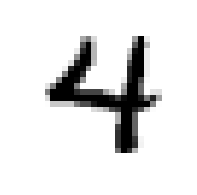

In [8]:
il[0].show()

In [9]:
sd = il.split_by_folder(train='training',valid='testing')

In [10]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /tmp/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /tmp/.fastai/data/mnist_png;

Test: None

In [11]:
(path/'training').ls()

[PosixPath('/tmp/.fastai/data/mnist_png/training/4'),
 PosixPath('/tmp/.fastai/data/mnist_png/training/5'),
 PosixPath('/tmp/.fastai/data/mnist_png/training/0'),
 PosixPath('/tmp/.fastai/data/mnist_png/training/7'),
 PosixPath('/tmp/.fastai/data/mnist_png/training/8'),
 PosixPath('/tmp/.fastai/data/mnist_png/training/2'),
 PosixPath('/tmp/.fastai/data/mnist_png/training/9'),
 PosixPath('/tmp/.fastai/data/mnist_png/training/3'),
 PosixPath('/tmp/.fastai/data/mnist_png/training/6'),
 PosixPath('/tmp/.fastai/data/mnist_png/training/1')]

In [12]:
ll = sd.label_from_folder()

In [13]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
4,4,4,4,4
Path: /tmp/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
4,4,4,4,4
Path: /tmp/.fastai/data/mnist_png;

Test: None

In [14]:
x,y = ll.train[0]

4 torch.Size([1, 28, 28])


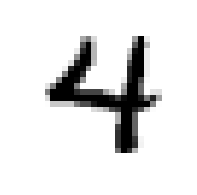

In [15]:
x.show()
print(y,x.shape)

In [16]:
tfms = ([*rand_pad(padding=3,size=28, mode='zeros')], [])

In [17]:
ll = ll.transform(tfms)

In [18]:
bs = 128

In [19]:
data = ll.databunch(bs=bs).normalize()

In [20]:
x,y = data.train_ds[0]

4


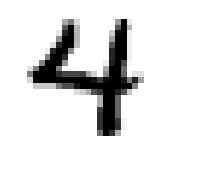

In [21]:
x.show()
print(y)

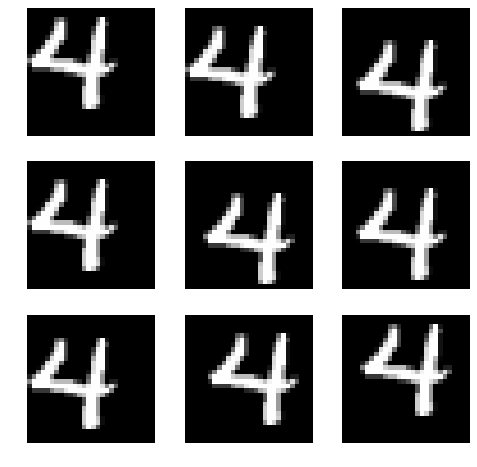

In [22]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

In [23]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

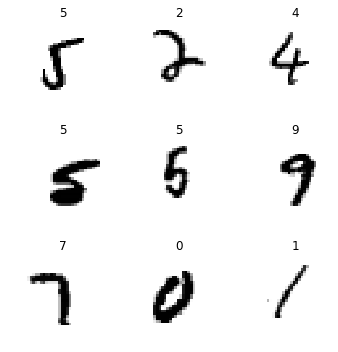

In [24]:
data.show_batch(rows=3, figsize=(5,5))

In [25]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [26]:
model = nn.Sequential(
    conv(1,8),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8,16),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16,32),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32,16),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16,10),
    nn.BatchNorm2d(10),
    Flatten()
)

In [27]:
learn  = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [28]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [29]:
xb = xb.cuda()

In [30]:
model(xb).shape

torch.Size([128, 10])

In [31]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


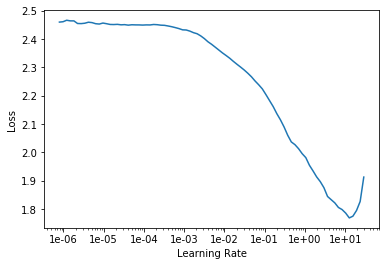

In [32]:
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.222097,0.402762,0.867400,00:37
1,0.141935,0.081706,0.974300,00:37
2,0.075564,0.041002,0.986100,00:37


In [34]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [35]:
model = nn.Sequential(
    conv2(1,8),
    conv2(8,16),
    conv2(16,32),
    conv2(32,16),
    conv2(16,10),
    Flatten()
)

In [36]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [37]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.239487,0.157369,0.951600,00:36
1,0.198146,0.146420,0.951400,00:36
2,0.155528,0.211172,0.929300,00:36
3,0.142279,0.107195,0.966700,00:36
4,0.116845,0.173948,0.947100,00:36
5,0.101633,0.068285,0.978700,00:36
6,0.084072,0.053244,0.983800,00:36
7,0.063310,0.040560,0.986200,00:36
8,0.050087,0.033316,0.989500,00:36


In [38]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
    
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [39]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense:bool=False, norm_type:Union[fastai.layers.NormType, NoneType]=<NormType.Batch: 1>, bottle:bool=False, **conv_kwargs)
    Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`.



In [40]:
model = nn.Sequential(
    conv2(1,8),
    res_block(8),
    conv2(8,16),
    res_block(16),
    conv2(16,32),
    res_block(32),
    conv2(32,16),
    res_block(16),
    conv2(16,10),
    Flatten()
)

In [41]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni,nf), res_block(nf))

In [42]:
model = nn.Sequential(
    conv_and_res(1,8),
    conv_and_res(8,16),
    conv_and_res(16,32),
    conv_and_res(32,16),
    conv2(16,10),
    Flatten()
)

In [43]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


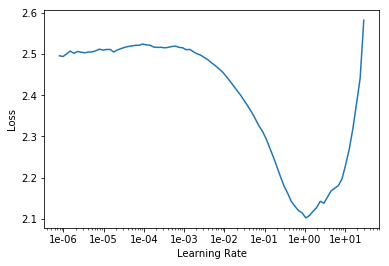

In [44]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [45]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.234912,0.141639,0.967200,00:40
1,0.133126,0.210990,0.933000,00:40
2,0.101759,0.085981,0.973000,00:40
3,0.095185,0.063469,0.979600,00:41
4,0.075683,0.064685,0.978600,00:41
5,0.065352,0.124479,0.962200,00:40
6,0.057299,0.048335,0.986000,00:41
7,0.044318,0.034925,0.988000,00:40
8,0.036864,0.020642,0.993000,00:41
9,0.029478,0.019356,0.993400,00:41


In [46]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
___________________________________________________